<table>
  <tr>
    <td><img src="https://github.com/rvss-australia/RVSS/blob/main/Pics/RVSS-logo-col.med.jpg?raw=1" width="400"></td>
    <td><div align="left"><font size="30">Modeling a perspective camera</font></div></td>
  </tr>
</table>

(c) Peter Corke 2024

Robotics, Vision & Control: Python, see section 13.2.2

## Configuring CoLab
To make this run nicely in CoLab we have to install a bunch of packages. This will be slow and at the end you will need to restart the kernel. Push the RESTART KERNEL button that appears or from the menu above Runtime/RestartRuntime

In [1]:
try:
    import google.colab
    print('Running on CoLab')
    !pip install machinevision-toolbox-python
    COLAB = True
except:
    COLAB = False

Now, we can import some of the packages we need throughout, Matplotlib and NumPy, and configure the CoLab environment a bit.

In [2]:
%matplotlib inline

import numpy as np
import math
from spatialmath import SE3
from spatialmath.base import e2h, h2e
import machinevisiontoolbox as mvtb

# From first principles

Let's define some parameters of our camera

In [3]:
f = 8*1e-3     # focal length in metres
rho = 10*1e-6  # pixel side length in metres
u0 = 500       # principal point, horizontal coordinate
v0 = 500       # principal point, vertical coordinate

Next we define some matrices.  

The first is a 3x3 _intrinsic_ matrix that contains information about the camera itself:
  - focal length of the lens
  - pixel size
  - the position of the principal point in units of pixels,this is where the _principal ray_ pierces the image plane.

In [4]:
K = np.array([  [f/rho, 0, u0], 
                [0, f/rho, v0], 
                [0, 0, 1]])

The next is a 3x4 matrix that performs the projection, reduces the 3D world point to a 2D image plane point

In [5]:
P0 = np.array([ [1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0]])

Then finally a 4x4 _extrinsic_ matrix_ which says how the camera is positioned and oriented in space. An identity matrix has our camera at the world frame origin and looking along the world z-axis.

In [6]:
X = np.identity(4)

We multiply these three matrices together to form the camera matrix

In [7]:
C = K @ P0 @ X

The resulting camera matrix is a 3x4 matrix

In [8]:
C.shape

(3, 4)

Next we define a point in terms of its 3D coordinates (in units of metres), as a column vector

In [9]:
P = np.array([1, -2, 5])

To perform the projection we need to convert our 3D coordinate to homogeneous form, which is done by the helper function `e2h`

In [10]:
e2h(P)

array([[ 1.],
       [-2.],
       [ 5.],
       [ 1.]])

Now we can premultiply this by the camera matrix to get the image plane coordinates in homoogeneous form

In [11]:
C @ e2h(P)

array([[3300.],
       [ 900.],
       [   5.]])

and we use the helper function `h2e` to convert that back to Euclidean coordinates - the 2D image plane coordinates in units of pixels

In [12]:
h2e( C @ e2h(P) )

array([[660.],
       [180.]])

If we move the point 0.5m in the x-axis direction we see that the u-coordinate in the image plane increases, as we would expect

In [13]:
P1 = np.array([3.5, 4, 5])
h2e( C @ e2h(P1) )

array([[1060.],
       [1140.]])

Now we will move the camera 0.5m in the x-axis direction. We do this by setting the top right element of the _extrinsic_ matrix so as to represent a translation of 0.5m.

Then we recompute the _camera_ matrix and project our original point onto the image plane of the moved camera.  We see that the u-coordinate has decreased as we would expect - when we move our head to the right the world appears to move to the left.

In [14]:
X[0,0] = 0.5
C = K @ P0 @ X
h2e( C @ e2h(P) )

array([[580.],
       [180.]])

# Using the Toolbox CentralCamera class



In [15]:
camera = mvtb.CentralCamera(f=f, rho=rho, pp=(u0, v0), imagesize=1000)
print(camera)

           Name: perspective [CentralCamera]
     pixel size: 9.999999999999999e-06 x 9.999999999999999e-06
     image size: 1000 x 1000
           pose: t = 0, 0, 0; rpy/yxz = 0°, 0°, 0°
   principal pt: [500. 500.]
   focal length: [0.008 0.008]



We can very conveniently project points to the image plane

In [16]:
camera.project_point(P)

array([[660.],
       [180.]])

and we can plot it on a virtual image plane conveniently by

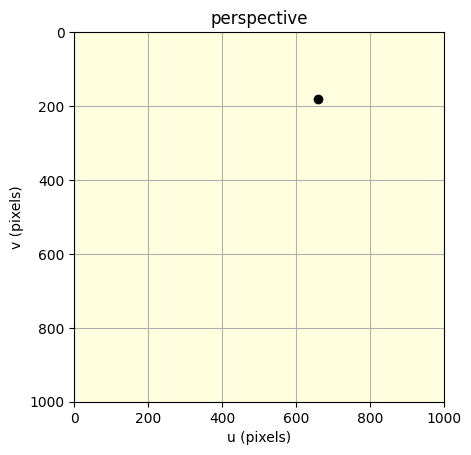

array([[660.],
       [180.]])

In [17]:
camera.plot_point(P)

We can project the same point, but this time with the camera moved 0.6m in the x-direction

In [18]:
camera.project_point(P, pose=SE3(0.6, 0, 0))

array([[564.],
       [180.]])

and we see that the u-coordinate has decreased.  If we look out along the camera's principal axis then moving the camera to the right causes the image plane point to move to the left.  Note that the vertical coordinate hasn't changed -- as expected.

We can extract the intrinsic matrix

In [19]:
camera.K

array([[800.,   0., 500.],
       [  0., 800., 500.],
       [  0.,   0.,   1.]])

and the camera matrix

In [20]:
camera.C()

array([[800.,   0., 500.,   0.],
       [  0., 800., 500.,   0.],
       [  0.,   0.,   1.,   0.]])